# Building an eccentric source model for Bilby using TEOBResumS

In [1]:
#!/home/anuj.mishra/.conda/envs/TEOBResumS-cloned/bin/python

import pycbc
import numpy as np
import bilby
from bilby.gw import source

from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/anuj.mishra/git_repos/GWMAT/src/')
import py_lgw
lgw = py_lgw.lensed_wf_gen()

sys.path.append('/home/anuj.mishra/git_repos/GWEAT/src/')
import TEOBResumS_utils as ecc_gen

import matplotlib.pyplot as plt
    

## 1. Checking the form of output for the default source models in Bilby

In [2]:
fs = np.arange(0, 1024, 1/4)
m1, m2 = 30, 30
a1, a2 = 0.1, 0.1
dL, theta_jn = 1000, np.pi/6

waveform_kwargs = dict(
        waveform_approximant='IMRPhenomXPHM', reference_frequency=20.0,
        minimum_frequency=20.0, maximum_frequency=fs[-1],
        catch_waveform_errors=False, pn_spin_order=-1, pn_tidal_order=-1,
        pn_phase_order=-1, pn_amplitude_order=0)

bilby_res = source.lal_binary_black_hole(fs, mass_1=m1, mass_2=m2, luminosity_distance=dL, a_1=a1, tilt_1=0, 
                      phi_12=0, a_2=a2, tilt_2=0, phi_jl=0, theta_jn=theta_jn, phase=0, **waveform_kwargs)

print(bilby_res.keys())
hp, hc = bilby_res['plus'], bilby_res['cross']

dict_keys(['plus', 'cross'])


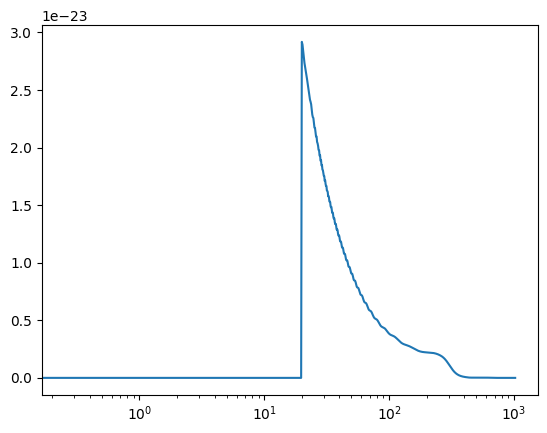

In [3]:
plt.plot(fs, np.abs(hp))
plt.xscale('log')
# plt.yscale('log')

In [4]:
len(fs), len(hp), len(hc)

(4096, 4096, 4096)

In [5]:
df = fs[1] - fs[0]
df

0.25

In [6]:
fdhp = pycbc.types.FrequencySeries(hp, delta_f=fs[1]-fs[0])
fdhc = pycbc.types.FrequencySeries(hc, delta_f=fs[1]-fs[0])

tdhp = fdhp.to_timeseries(delta_t=fdhp.delta_t)
tdhc = fdhc.to_timeseries(delta_t=fdhc.delta_t)

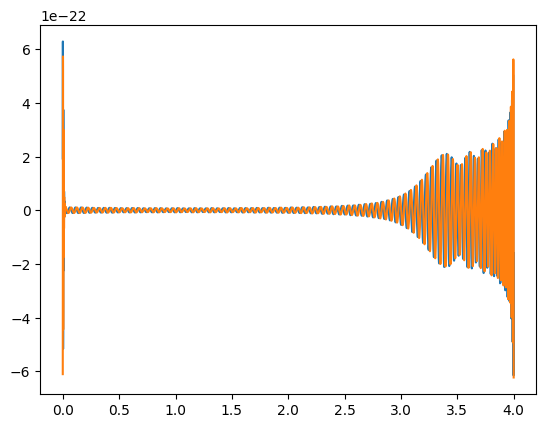

In [7]:
plt.plot(tdhp.sample_times, tdhp)
plt.plot(tdhc.sample_times, tdhc)

### Conclusion: Bilby's FD source model is such that it keeps the peaks of the strains at t=0.

## 2. Building an eccentric source model using TEOBResumS

### TD Source Model: v1

In [8]:
import numpy as np
import sys
from pycbc.waveform import utils
from scipy.interpolate import interp1d
sys.path.append('/home/anuj.mishra/git_repos/GWEAT/src/')
import TEOBResumS_utils as ecc_gen
import importlib
importlib.reload(ecc_gen) 


def eccentric_BBH_TD_v1(mass_1, mass_2, luminosity_distance, chi_1z, chi_2z,
                          theta_jn, phase, ecc, **kwargs):
    modes_list = ecc_gen.modes_to_k([[2,2], [2,1], [2,3], [3,2], [3,3]])
    waveform_kwargs = dict(
    f_start=10, sample_rate=4096, modes_list=modes_list,
    ecc_freq=2, ode_abstol=1e-13, ode_reltol=1e-11,
    )
    waveform_kwargs.update(kwargs)
    
    #https://bitbucket.org/eob_ihes/teobresums/wiki/Conventions,%20parameters%20and%20output 
    pars = {
            'mass_1'             : mass_1,
            'mass_2'             : mass_2,
            'chi1z'              : chi_1z,
            'chi2z'              : chi_2z,
            'luminosity_distance': luminosity_distance,
            'inclination'        : theta_jn,  
            'coa_phase'          : phase,
            'use_mode_lm'        : waveform_kwargs['modes_list'],   #List of modes to use/output through EOBRunPy
            'output_lm'          : waveform_kwargs['modes_list'],   #List of modes to print on file
            'srate_interp'       : waveform_kwargs['sample_rate'],  #srate at which to interpolate. Default = 4096.
            'initial_frequency'  : waveform_kwargs['f_start'],      #in Hz if use_geometric_units = 0, else in geometric units
            'ecc'                : ecc,     #Eccentricity. Default = 0.
            'ecc_freq'           : waveform_kwargs['ecc_freq'],      #Use periastron (0), average (1) or apastron (2) frequency for initial condition computation. Default = 1
            'ode_abstol'         : waveform_kwargs['ode_abstol'],
            'ode_reltol'         : waveform_kwargs['ode_reltol']
           }
    try:
        pars.update(waveform_kwargs)
        wfs_res = ecc_gen.teobresums_td_pure_polarized_wf_gen(**pars)
        hp, hc = wfs_res['hp'], wfs_res['hc']
        return dict(plus = hp, cross = hc)
    except Exception as e:
        print(e)
        pass

In [9]:
# # checking if input parameters are correctly passed to the WF generator
# fs = np.arange(0, 1024, 1/4)
# modes_list = ecc_gen.modes_to_k([[2,2],[3,3]])
# kwargs = dict(f_start=10, modes_list=modes_list, f_low=40, sample_rate=8192)
# pars = eccentric_BBH(frequency_array=fs, mass_1=40, mass_2=30, luminosity_distance=150, chi_1z=0.33, chi_2z=0.45,
#                           theta_jn=0.74, phase=0.05, ecc=0.1, **kwargs)   

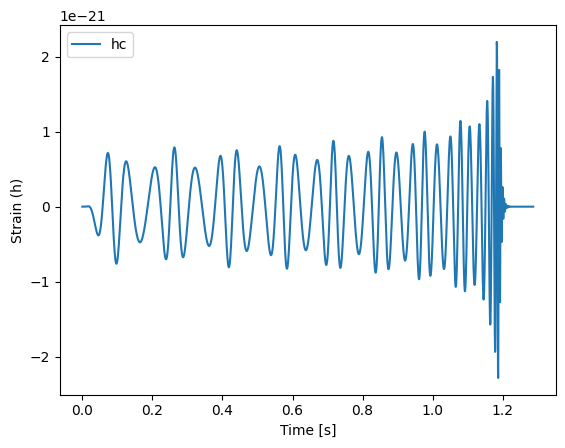

In [10]:
kwargs = dict(f_start=10, f_low=20, sample_rate=2048)
wfs_res = eccentric_BBH_TD_v1(mass_1=50, mass_2=30, luminosity_distance=400, chi_1z=0., chi_2z=0.,
                          theta_jn=0., phase=0., ecc=0.2, **kwargs)   
hp, hc = wfs_res['plus'], wfs_res['cross']

wf = hp
plt.plot(wf.sample_times, wf, label='hc')
plt.xlabel('Time [s]')
plt.ylabel('Strain (h)')
plt.legend()
plt.show()

### TD Source Model: v2
TD model that gives output in a form similar to Bilby's TD WF, i.e., peak at t=0.

In [11]:
import numpy as np
import sys
from pycbc.waveform import utils
from scipy.interpolate import interp1d
sys.path.append('/home/anuj.mishra/git_repos/GWEAT/src/')
import TEOBResumS_utils as ecc_gen
import importlib
importlib.reload(ecc_gen) 


def cyclic_time_shift_of_WF(wf, rwrap=0.2):
        """
        Inspired by PyCBC's function pycbc.types.TimeSeries.cyclic_time_shift(), 
        it shifts the data and timestamps in the time domain by a given number of seconds (rwrap). 
        Difference between this and PyCBCs function is that this function preserves the sample rate of the WFs while cyclically rotating, 
        but the time shift cannot be smaller than the intrinsic sample rate of the data, unlike PyCBc's function.
        To just change the time stamps, do ts.start_time += dt.
        Note that data will be cyclically rotated, so if you shift by 2
        seconds, the final 2 seconds of your data will now be at the
        beginning of the data set.

        Parameters
        ----------
        wf : pycbc.types.TimeSeries
            The waveform for cyclic rotation.
        rwrap : float, optional
            Amount of time to shift the vector. Default = 0.2.

        Returns
        -------
        pycbc.types.TimeSeries
            The time shifted time series.

        """        

        # This function does cyclic time shift of a WF.
        # It is similar to PYCBC's "cyclic_time_shift" except for the fact that it also preserves the Sample Rate of the original WF.
        if rwrap is not None and rwrap != 0:
            sn = abs(int(rwrap/wf.delta_t))     # number of elements to be shifted 
            cycles = int(sn/len(wf))

            cyclic_shifted_wf = wf.copy()

            sn_new = sn - int(cycles * len(wf))

            if rwrap > 0:
                epoch = wf.sample_times[0] - sn_new * wf.delta_t
                if sn_new != 0:
                    wf_arr = np.array(wf).copy()
                    tmp_wf_p1 = wf_arr[-sn_new:]
                    tmp_wf_p2 = wf_arr[:-sn_new] 
                    shft_wf_arr = np.concatenate(( tmp_wf_p1, tmp_wf_p2 ))
                    cyclic_shifted_wf = pycbc.types.TimeSeries(shft_wf_arr, delta_t = wf.delta_t, epoch = epoch)
            else:
                epoch = wf.sample_times[sn_new]
                if sn_new != 0:
                    wf_arr = np.array(wf).copy()
                    tmp_wf_p1 = wf_arr[sn_new:] 
                    tmp_wf_p2 = wf_arr[:sn_new]
                    shft_wf_arr = np.concatenate(( tmp_wf_p1, tmp_wf_p2 ))
                    cyclic_shifted_wf = pycbc.types.TimeSeries(shft_wf_arr, delta_t = wf.delta_t, epoch = epoch)  

            for i in range(cycles):        
                    epoch = epoch - np.sign(rwrap)*wf.duration
                    wf_arr = np.array(cyclic_shifted_wf)[:]
                    cyclic_shifted_wf = pycbc.types.TimeSeries(wf_arr, delta_t = wf.delta_t, epoch = epoch)

            assert len(cyclic_shifted_wf) == len(wf), 'Length mismatch: cyclic time shift added extra length to WF.'
            return cyclic_shifted_wf
        else:
            return wf
        
def determine_time_shift(wf):
    wf_dt = wf.sample_times[1] - wf.sample_times[0]
    wf_end_time = wf.sample_times[-1] + wf_dt
    peak_time = wf.sample_times[np.argmax(np.array(wf))]
    t_shift = wf_end_time - peak_time
    return t_shift     

def eccentric_BBH_TD(mass_1, mass_2, luminosity_distance, chi_1z, chi_2z,
                          theta_jn, phase, ecc, **kwargs):
    
    modes_list = ecc_gen.modes_to_k([[2,2], [2,1], [2,3], [3,2], [3,3]])
    waveform_kwargs = dict(
    f_start=10, sample_rate=4096, modes_list=modes_list,
    ecc_freq=2, ode_abstol=1e-13, ode_reltol=1e-11,
    )
    waveform_kwargs.update(kwargs)

    #https://bitbucket.org/eob_ihes/teobresums/wiki/Conventions,%20parameters%20and%20output 
    pars = {
            'mass_1'             : mass_1,
            'mass_2'             : mass_2,
            'chi1z'              : chi_1z,
            'chi2z'              : chi_2z,
            'luminosity_distance': luminosity_distance,
            'inclination'        : theta_jn,  
            'coa_phase'          : phase,
            'use_mode_lm'        : waveform_kwargs['modes_list'],   #List of modes to use/output through EOBRunPy
            'output_lm'          : waveform_kwargs['modes_list'],   #List of modes to print on file
            'srate_interp'       : waveform_kwargs['sample_rate'],  #srate at which to interpolate. Default = 4096.
            'initial_frequency'  : waveform_kwargs['f_start'],      #in Hz if use_geometric_units = 0, else in geometric units
            'ecc'                : ecc,     #Eccentricity. Default = 0.
            'ecc_freq'           : waveform_kwargs['ecc_freq'],      #Use periastron (0), average (1) or apastron (2) frequency for initial condition computation. Default = 1
            'ode_abstol'         : waveform_kwargs['ode_abstol'],
            'ode_reltol'         : waveform_kwargs['ode_reltol']
           }
    try:
        pars.update(waveform_kwargs)
        wfs_res = ecc_gen.teobresums_td_pure_polarized_wf_gen(**pars)
        hp, hc = wfs_res['hp'], wfs_res['hc']
        
        # shifting the peak of the WF to t=0.
        wf = hp - 1j * hc
        wf = cyclic_time_shift_of_WF(wf, rwrap=determine_time_shift(wf)) 
        wf.start_time=0
        hp, hc = wf.real(), wf.imag()
        return dict(plus = hp, cross = hc)
    
    except Exception as e:
        print(e)
        pass

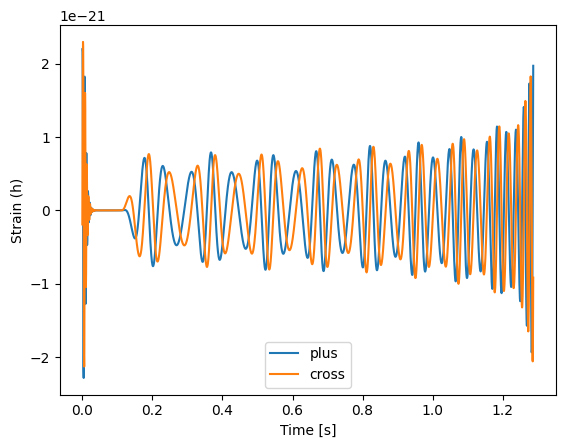

In [12]:
fs = np.arange(0, 1024, 1/4)
kwargs = dict(f_start=10, f_low=20, sample_rate=2048)
wfs_res = eccentric_BBH_TD(mass_1=50, mass_2=30, luminosity_distance=400, chi_1z=0., chi_2z=0.,
                          theta_jn=0., phase=0., ecc=0.2, **kwargs)   

for k in wfs_res.keys():
    wf = wfs_res[k]
    plt.plot(wf.sample_times, wf, label=k)
plt.xlabel('Time [s]')
plt.ylabel('Strain (h)')
plt.legend()
plt.show()

### FD Source Model: v1
v1: using df of the frequecy array for FFT.

In [13]:
def eccentric_BBH_FD_v1(frequency_array, mass_1, mass_2, luminosity_distance, chi_1z, chi_2z,
                          theta_jn, phase, ecc, **kwargs):
    wfs_res = eccentric_BBH_TD(mass_1, mass_2, luminosity_distance, chi_1z, chi_2z,
                          theta_jn, phase, ecc, **kwargs)
    hp, hc = wfs_res['plus'], wfs_res['cross']
    
    df = frequency_array[1] - frequency_array[0]
    fd_hp = hp.to_frequencyseries(delta_f=df)
    fd_hc = hc.to_frequencyseries(delta_f=df)
    return dict(plus = fd_hp, cross = fd_hc)

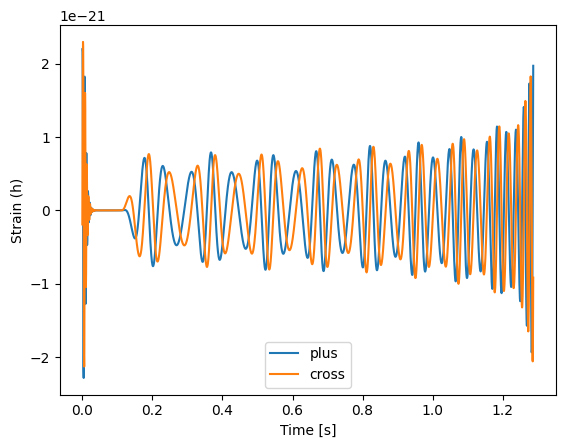

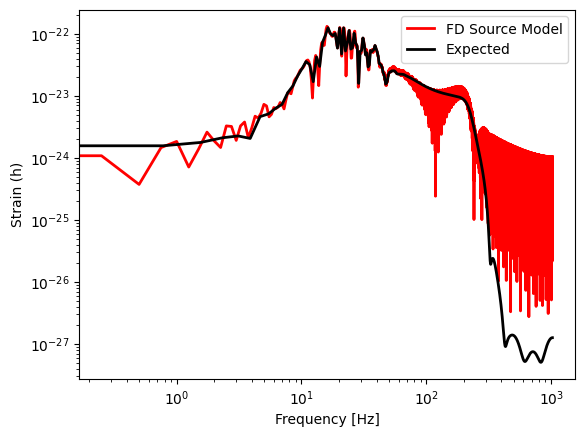

In [14]:
fs = np.arange(0, 1024, 1/4)
kwargs = dict(f_start=10, f_low=20, sample_rate=2048)
wfs_res = eccentric_BBH_TD(mass_1=50, mass_2=30, luminosity_distance=400, chi_1z=0., chi_2z=0.,
                          theta_jn=0., phase=0., ecc=0.2, **kwargs)   
hp = wfs_res['plus']
for k in wfs_res.keys():
    wf = wfs_res[k]
    plt.plot(wf.sample_times, wf, label=k)
plt.xlabel('Time [s]')
plt.ylabel('Strain (h)')
plt.legend()
plt.show()


fs = np.arange(0, 1024, 1/4)
kwargs = dict(f_start=10, f_low=20, sample_rate=2048)
wfs_res = eccentric_BBH_FD_v1(frequency_array=fs, mass_1=50, mass_2=30, luminosity_distance=400, chi_1z=0., chi_2z=0.,
                          theta_jn=0., phase=0., ecc=0.2, **kwargs)   
for k in list(wfs_res.keys())[:1]:
    wf = wfs_res[k]
    plt.plot(wf.sample_frequencies, np.abs(wf), label='FD Source Model', linewidth=2, color='red')
    
fd_hp = hp.to_frequencyseries(delta_f=hp.delta_f)
wf = fd_hp
plt.plot(wf.sample_frequencies, np.abs(wf), label='Expected', linewidth=2, color='black')

plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain (h)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

#### conclusion (v1): this method gives spurious outputs at higher frequencies.

### FD Source Model: v2
v2: Interpolating the FD WF to evaluate at the required frequency_array.

In [15]:
def eccentric_BBH_FD_v2(frequency_array, mass_1, mass_2, luminosity_distance, chi_1z, chi_2z,
                          theta_jn, phase, ecc, **kwargs):
    modes_list = ecc_gen.modes_to_k([[2,2], [2,1], [2,3], [3,2], [3,3]])
    waveform_kwargs = dict(
    waveform_approximant='IMRPhenomPv2', reference_frequency=20.0,
    minimum_frequency=20.0, maximum_frequency=frequency_array[-1],
    f_start=5, sample_rate=4096, modes_list=modes_list)
    waveform_kwargs.update(kwargs)
        
    wfs_res = eccentric_BBH_TD(mass_1, mass_2, luminosity_distance, chi_1z, chi_2z,
                          theta_jn, phase, ecc, **waveform_kwargs)
    hp, hc = wfs_res['plus'], wfs_res['cross']
    
    # converting WFs from TD -> FD 
    fd_hp = hp.to_frequencyseries(delta_f=hp.delta_f)
    fd_hc = hc.to_frequencyseries(delta_f=hc.delta_f)
    
    # interpolating for given freqeuncy array
    ifd_hp = interp1d(fd_hp.sample_frequencies, fd_hp, kind='linear')
    ifd_hc = interp1d(fd_hc.sample_frequencies, fd_hc, kind='quadratic')
    fd_hp_arr = ifd_hp(frequency_array)
    fd_hc_arr = ifd_hc(frequency_array)
    # frequency_bounds = (frequency_array >=frequency_array[0]) * (frequency_array <= waveform_kwargs['maximum_frequency'])
    frequency_bounds = (frequency_array >=frequency_array[0]) * (frequency_array <= frequency_array[-2])
    fd_hp_arr *= frequency_bounds
    fd_hc_arr *= frequency_bounds
    df = frequency_array[1] - frequency_array[0]
    
    # Converting to PyCBC Frequency Series
    FD_hp = pycbc.types.FrequencySeries(fd_hp_arr, delta_f=df, epoch=0)
    FD_hc = pycbc.types.FrequencySeries(fd_hc_arr, delta_f=df, epoch=0)
    # return dict(plus = FD_hp, cross = FD_hc)
    return dict(interped = FD_hp, true = fd_hp)   # returning this for testing purpose

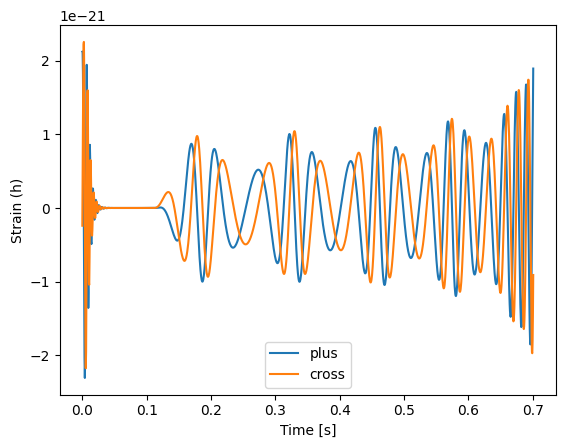

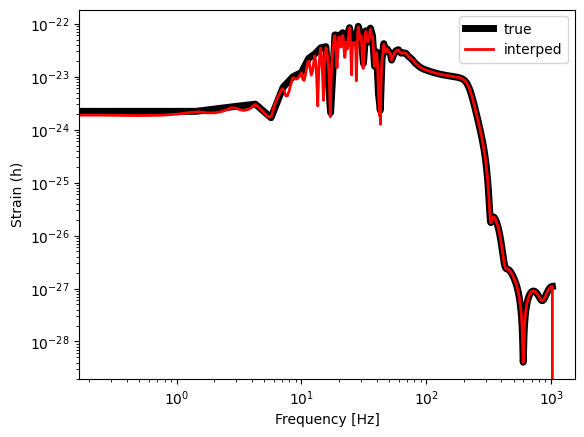

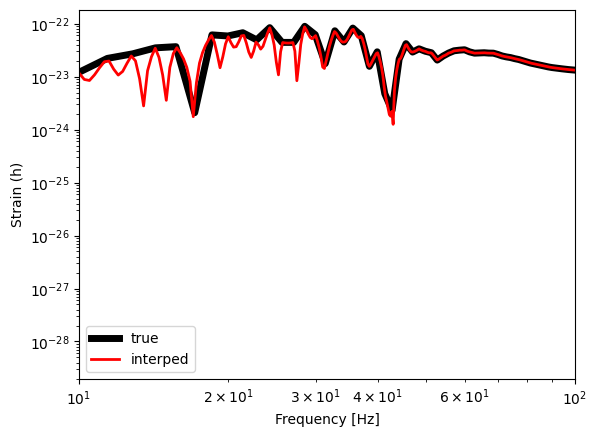

In [16]:
# Input WF args
fs = np.arange(0, 1024, 1/4)
kwargs = dict(f_start=10, f_low=20, sample_rate=2048)

# Generating TD WF
wfs_res = eccentric_BBH_TD(mass_1=50, mass_2=30, luminosity_distance=400, chi_1z=0., chi_2z=0.,
                          theta_jn=0., phase=0., ecc=0.3, **kwargs)   
for k in wfs_res.keys():
    wf = wfs_res[k]
    plt.plot(wf.sample_times, wf, label=k)
plt.xlabel('Time [s]')
plt.ylabel('Strain (h)')
plt.legend()
plt.show()

# Generating FD WF
wfs_res = eccentric_BBH_FD_v2(frequency_array=fs, mass_1=50, mass_2=30, luminosity_distance=400, chi_1z=0., chi_2z=0.,
                          theta_jn=0., phase=0., ecc=0.3, **kwargs)  

# Plotting and Comparing
for n,k in enumerate(list(wfs_res.keys())[::-1]):
    wf = wfs_res[k]
    if n==0:
        plt.plot(wf.sample_frequencies, np.abs(wf), label=k, linewidth=5, color='black')     
    if n==1:
        plt.plot(wf.sample_frequencies, np.abs(wf), label=k, linewidth=2, color='red')   
plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain (h)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

for n,k in enumerate(list(wfs_res.keys())[::-1]):
    wf = wfs_res[k]
    if n==0:
        plt.plot(wf.sample_frequencies, np.abs(wf), label=k, linewidth=5, color='black')     
    if n==1:
        plt.plot(wf.sample_frequencies, np.abs(wf), label=k, linewidth=2, color='red') 
plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain (h)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(10, 100)
plt.show()

with a high sample rate

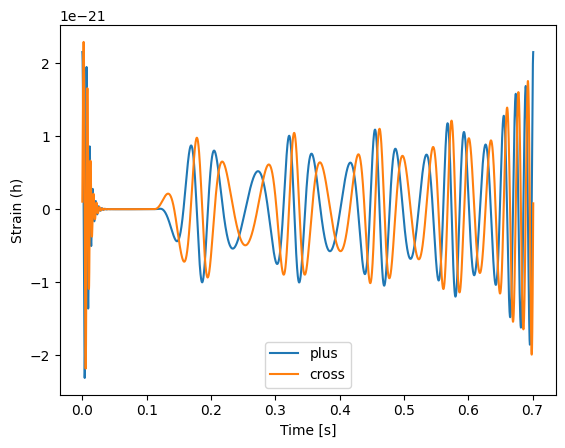

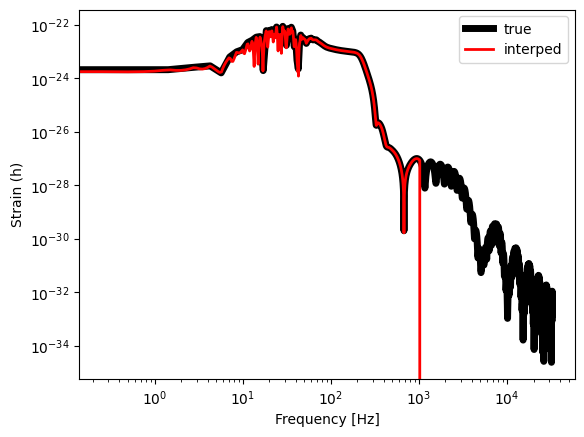

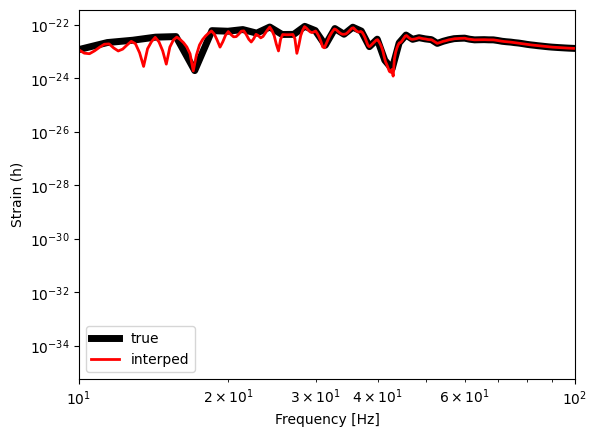

In [17]:
# Input WF args
fs = np.arange(0, 1024, 1/4)
kwargs = dict(f_start=10, f_low=20, sample_rate=65536)

# Generating TD WF
wfs_res = eccentric_BBH_TD( mass_1=50, mass_2=30, luminosity_distance=400, chi_1z=0., chi_2z=0.,
                          theta_jn=0., phase=0., ecc=0.3, **kwargs)   
for k in wfs_res.keys():
    wf = wfs_res[k]
    plt.plot(wf.sample_times, wf, label=k)
plt.xlabel('Time [s]')
plt.ylabel('Strain (h)')
plt.legend()
plt.show()

# Generating FD WF
wfs_res = eccentric_BBH_FD_v2(frequency_array=fs, mass_1=50, mass_2=30, luminosity_distance=400, chi_1z=0., chi_2z=0.,
                          theta_jn=0., phase=0., ecc=0.3, **kwargs)   

# Plotting and Comparing
for n,k in enumerate(list(wfs_res.keys())[::-1]):
    wf = wfs_res[k]
    if n==0:
        plt.plot(wf.sample_frequencies, np.abs(wf), label=k, linewidth=5, color='black')     
    if n==1:
        plt.plot(wf.sample_frequencies, np.abs(wf), label=k, linewidth=2, color='red')   
plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain (h)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

for n,k in enumerate(list(wfs_res.keys())[::-1]):
    wf = wfs_res[k]
    if n==0:
        plt.plot(wf.sample_frequencies, np.abs(wf), label=k, linewidth=5, color='black')     
    if n==1:
        plt.plot(wf.sample_frequencies, np.abs(wf), label=k, linewidth=2, color='red') 
plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain (h)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(10, 100)
plt.show()

#### conclusion (v2): this method gives spurious outputs at lower frequencies. I experimented with changing `kinds` argument of interp1d interpolation, such as quadratic and cubic, but nothing worked well. Also, increasing sample rate didn't help.

### FD Source Model: v3
v3: Experimenting with the interpolation: Doing interpolation in log scale rather than the linear.

In [18]:
# def eccentric_BBH_FD_v3(frequency_array, mass_1, mass_2, luminosity_distance, chi_1z, chi_2z,
#                           theta_jn, phase, ecc, **kwargs):
#     modes_list = ecc_gen.modes_to_k([[2,2], [2,1], [2,3], [3,2], [3,3]])
#     waveform_kwargs = dict(
#     waveform_approximant='IMRPhenomPv2', reference_frequency=20.0,
#     minimum_frequency=20.0, maximum_frequency=frequency_array[-1],
#     f_start=5, sample_rate=4096, modes_list=modes_list)
#     waveform_kwargs.update(kwargs)
        
#     wfs_res = eccentric_BBH_TD(frequency_array, mass_1, mass_2, luminosity_distance, chi_1z, chi_2z,
#                           theta_jn, phase, ecc, **waveform_kwargs)
#     hp, hc = wfs_res['plus'], wfs_res['cross']
    
#     # converting WFs from TD -> FD 
#     fd_hp = hp.to_frequencyseries(delta_f=hp.delta_f)
#     fd_hc = hc.to_frequencyseries(delta_f=hc.delta_f)
    
#     fd_hp_arr = np.log10(np.array(fd_hp))
#     fd_hc_arr = np.log10(np.array(fd_hc))
    
#     # interpolating for given freqeuncy array
#     ifd_hp = interp1d(fd_hp.sample_frequencies[:], fd_hp_arr[:], kind='linear')
#     ifd_hc = interp1d(fd_hc.sample_frequencies[:], fd_hc_arr[:], kind='linear')
#     fd_hp_arr = np.concatenate(([0], 10**ifd_hp(frequency_array[1:])))
#     fd_hc_arr = np.concatenate(([0], 10**ifd_hc(frequency_array[1:])))
#     # frequency_bounds = (frequency_array >=frequency_array[0]) * (frequency_array <= waveform_kwargs['maximum_frequency'])
#     frequency_bounds = (frequency_array >=frequency_array[0]) * (frequency_array <= frequency_array[-2])
#     fd_hp_arr *= frequency_bounds
#     fd_hc_arr *= frequency_bounds
#     df = frequency_array[1] - frequency_array[0]
    
#     # Converting to PyCBC Frequency Series
#     FD_hp = pycbc.types.FrequencySeries(fd_hp_arr, delta_f=df, epoch=0)
#     FD_hc = pycbc.types.FrequencySeries(fd_hc_arr, delta_f=df, epoch=0)
#     # return dict(plus = FD_hp, cross = FD_hc)
#     return dict(interped = FD_hp, true = fd_hp)   # returning this for testing purpose



def eccentric_BBH_FD_v3(frequency_array, mass_1, mass_2, luminosity_distance, chi_1z, chi_2z,
                          theta_jn, phase, ecc, **kwargs):
    modes_list = ecc_gen.modes_to_k([[2,2], [2,1], [2,3], [3,2], [3,3]])
    waveform_kwargs = dict(
    waveform_approximant='IMRPhenomPv2', reference_frequency=20.0,
    minimum_frequency=20.0, maximum_frequency=frequency_array[-1],
    f_start=5, sample_rate=4096, modes_list=modes_list)
    waveform_kwargs.update(kwargs)
        
    wfs_res = eccentric_BBH_TD(mass_1, mass_2, luminosity_distance, chi_1z, chi_2z,
                          theta_jn, phase, ecc, **waveform_kwargs)
    
    df = frequency_array[1] - frequency_array[0]
    
    res = dict()
    true_res = dict()
    for k in wfs_res.keys():
        wf = wfs_res[k]
        
        ## converting TD WF -> FD WF 
        fd_wf = wf.to_frequencyseries(delta_f=wf.delta_f)
        
        ## interpolating for given freqeuncy array
        fd_wf_arr = np.log10(np.array(fd_wf))
        ifd_wf = interp1d(fd_wf.sample_frequencies[:], fd_wf_arr[:], kind='linear')
        fd_wf_arr = np.concatenate(([0], 10**ifd_wf(frequency_array[1:])))
        #frequency_bounds = (frequency_array >=frequency_array['minimum_frequency']) * (frequency_array <= waveform_kwargs['maximum_frequency'])
        frequency_bounds = (frequency_array >=frequency_array[0]) * (frequency_array <= frequency_array[-1])
        fd_wf_arr *= frequency_bounds
        
        ## Converting to PyCBC Frequency Series
        FD_wf = pycbc.types.FrequencySeries(fd_wf_arr, delta_f=df, epoch=0)
        res[k] = FD_wf
        true_res[k] = fd_wf
    #return res
    return dict(interped = res['plus'], true = true_res['plus'])   # returning this for testing purpose

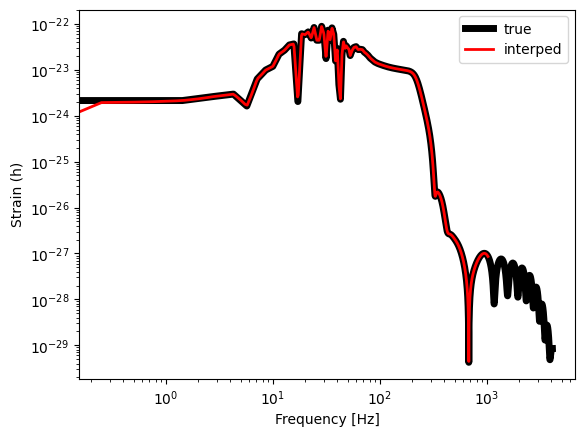

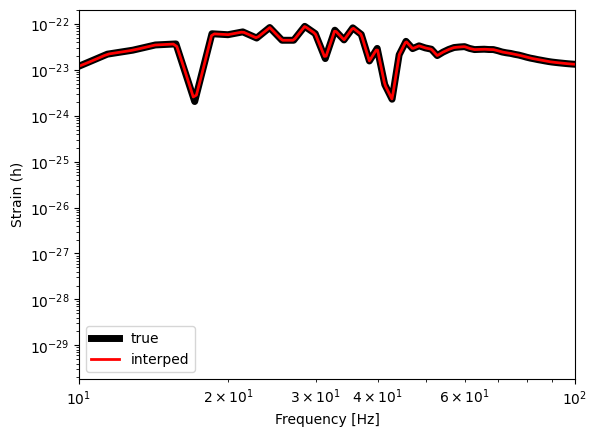

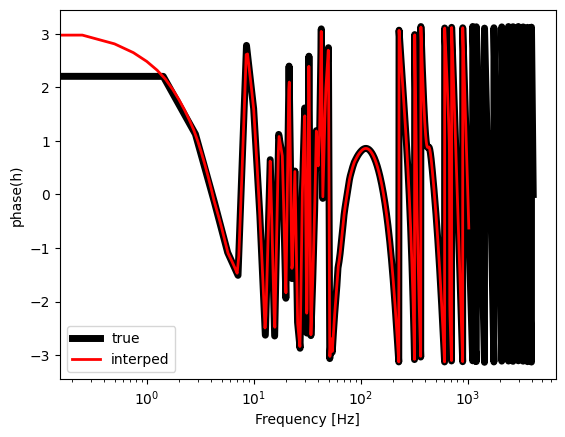

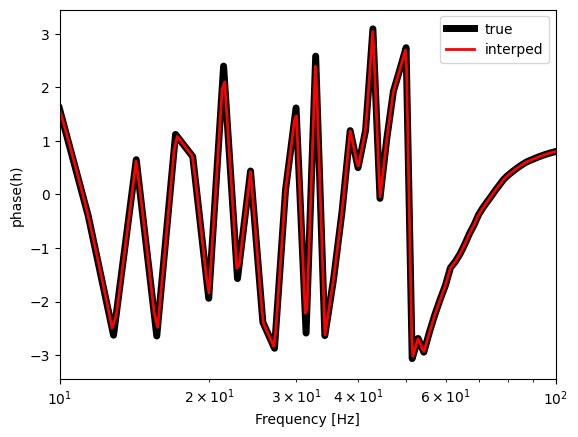

In [19]:
# Input WF args
fs = np.arange(0, 1024, 1/4)
kwargs = dict(f_start=10, f_low=20, sample_rate=8192)

# Generating FD WF
wfs_res = eccentric_BBH_FD_v3(frequency_array=fs, mass_1=50, mass_2=30, luminosity_distance=400, chi_1z=0., chi_2z=0.,
                          theta_jn=0., phase=0., ecc=0.3, **kwargs)   


# Plotting and Comparing (absolute value)
for n,k in enumerate(list(wfs_res.keys())[::-1]):
    wf = wfs_res[k]
    if n==0:
        plt.plot(wf.sample_frequencies, np.abs(wf), label=k, linewidth=5, color='black')     
    if n==1:
        plt.plot(wf.sample_frequencies, np.abs(wf), label=k, linewidth=2, color='red')   
plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain (h)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

for n,k in enumerate(list(wfs_res.keys())[::-1]):
    wf = wfs_res[k]
    if n==0:
        plt.plot(wf.sample_frequencies, np.abs(wf), label=k, linewidth=5, color='black')     
    if n==1:
        plt.plot(wf.sample_frequencies, np.abs(wf), label=k, linewidth=2, color='red') 
plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain (h)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(10, 100)
plt.show()

# Plotting and Comparing (Phase)
for n,k in enumerate(list(wfs_res.keys())[::-1]):
    wf = wfs_res[k]
    if n==0:
        plt.plot(wf.sample_frequencies, np.angle(wf), label=k, linewidth=5, color='black')     
    if n==1:
        plt.plot(wf.sample_frequencies, np.angle(wf), label=k, linewidth=2, color='red')   
plt.xlabel('Frequency [Hz]')
plt.ylabel('phase(h)')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

for n,k in enumerate(list(wfs_res.keys())[::-1]):
    wf = wfs_res[k]
    if n==0:
        plt.plot(wf.sample_frequencies, np.angle(wf), label=k, linewidth=5, color='black')     
    if n==1:
        plt.plot(wf.sample_frequencies, np.angle(wf), label=k, linewidth=2, color='red') 
plt.xlabel('Frequency [Hz]')
plt.ylabel('phase(h)')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.xlim(10, 100)
plt.show()

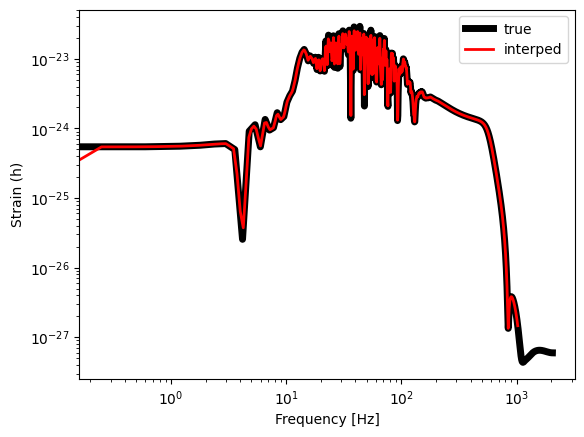

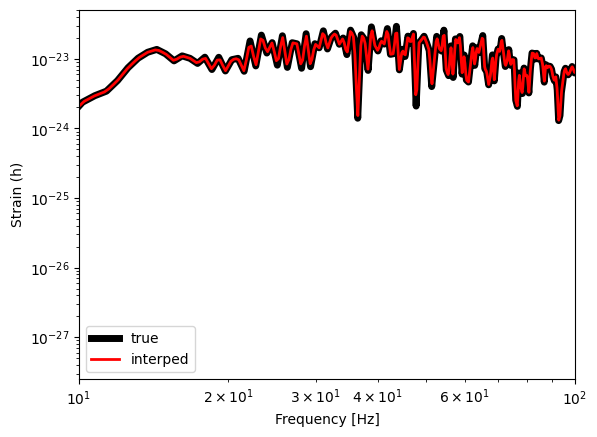

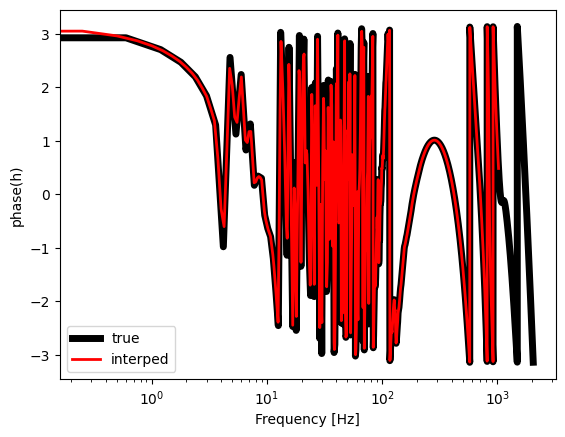

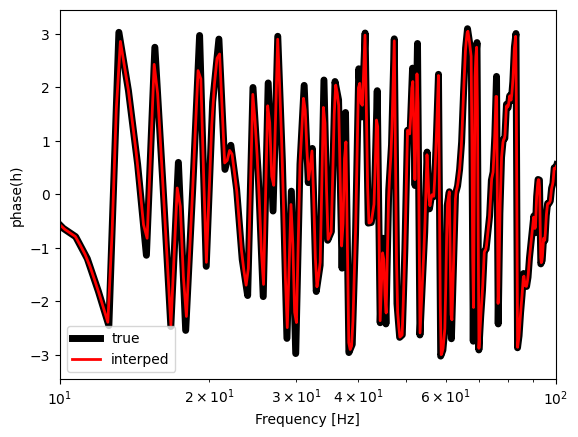

In [20]:
# Input WF args
fs = np.arange(0, 1024, 1/4)
kwargs = dict(f_start=10, f_low=20, sample_rate=4096)

# Generating FD WF
wfs_res = eccentric_BBH_FD_v3(frequency_array=fs, mass_1=20, mass_2=10, luminosity_distance=400, chi_1z=0., chi_2z=0.,
                          theta_jn=0., phase=0., ecc=0.4, **kwargs)  


# Plotting and Comparing (absolute value)
for n,k in enumerate(list(wfs_res.keys())[::-1]):
    wf = wfs_res[k]
    if n==0:
        plt.plot(wf.sample_frequencies, np.abs(wf), label=k, linewidth=5, color='black')     
    if n==1:
        plt.plot(wf.sample_frequencies, np.abs(wf), label=k, linewidth=2, color='red')   
plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain (h)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

for n,k in enumerate(list(wfs_res.keys())[::-1]):
    wf = wfs_res[k]
    if n==0:
        plt.plot(wf.sample_frequencies, np.abs(wf), label=k, linewidth=5, color='black')     
    if n==1:
        plt.plot(wf.sample_frequencies, np.abs(wf), label=k, linewidth=2, color='red') 
plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain (h)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(10, 100)
plt.show()

# Plotting and Comparing (Phase)
for n,k in enumerate(list(wfs_res.keys())[::-1]):
    wf = wfs_res[k]
    if n==0:
        plt.plot(wf.sample_frequencies, np.angle(wf), label=k, linewidth=5, color='black')     
    if n==1:
        plt.plot(wf.sample_frequencies, np.angle(wf), label=k, linewidth=2, color='red')   
plt.xlabel('Frequency [Hz]')
plt.ylabel('phase(h)')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

for n,k in enumerate(list(wfs_res.keys())[::-1]):
    wf = wfs_res[k]
    if n==0:
        plt.plot(wf.sample_frequencies, np.angle(wf), label=k, linewidth=5, color='black')     
    if n==1:
        plt.plot(wf.sample_frequencies, np.angle(wf), label=k, linewidth=2, color='red') 
plt.xlabel('Frequency [Hz]')
plt.ylabel('phase(h)')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.xlim(10, 100)
plt.show()

#### conclusion (v3): Doing interpolation in log scale resolves the issue of spurious outputs in lower frequencies and gives consistent result with the expected FD WF. Hence, this is what we will use for PE :) .